## Week 10 Homework, Natural Language Processing

### Imports

In [41]:
import pandas as pd
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### 1. Read yelp.csv into a DataFrame.

In [42]:
yelp_data = pd.read_csv('../../DAT-DC-10/data/yelp.csv')

### 2. Create a new DataFrame that only contains the 5-star and 1-star reviews.

In [43]:
yelp_ext = yelp_data[(yelp_data['stars'] == 1) | (yelp_data['stars'] == 5)]

### 3. Split the new DataFrame into training and testing sets, using the review text as the only feature and the star rating as the response.

In [44]:
X = yelp_ext['text']
y = yelp_ext['stars']
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=3)
# to test against solution
#Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=1)

### 4. Use CountVectorizer to create document-term matrices from X_train and X_test.
**Hint**: If you run into a decoding error, instantiate the vectorizer with the argument decode_error='ignore'.

In [45]:
vect = CountVectorizer()
vect.fit(Xtrain)
yelp_train_dtm = vect.transform(Xtrain)
yelp_test_dtm = vect.transform(Xtest)

In [46]:
yelp_train_dtm.shape

(3268, 17135)

In [47]:
yelp_test_dtm.shape

(818, 17135)

### 5. Use Naive Bayes to predict the star rating for reviews in the testing set, and calculate the accuracy.

In [48]:
nb = MultinomialNB()
nb.fit(yelp_train_dtm, ytrain)
y_pred = nb.predict(yelp_test_dtm)
metrics.accuracy_score(ytest, y_pred)

0.9193154034229829

### 6. Calculate the AUC.

**Hint 1:** Make sure to pass the predicted probabilities to roc_auc_score, not the predicted classes.

**Hint 2:** roc_auc_score will get confused if y_test contains fives and ones, so you will need to create a new object that contains ones and zeros instead.

In [49]:
y_pred_prob = nb.predict_proba(yelp_test_dtm)
y_pred_pos = y_pred_prob[:,1]
y_tf = np.where(ytest==1,0,1)
metrics.roc_auc_score(y_tf, y_pred_pos)

0.94563674721902569

### 7. Plot the ROC curve.

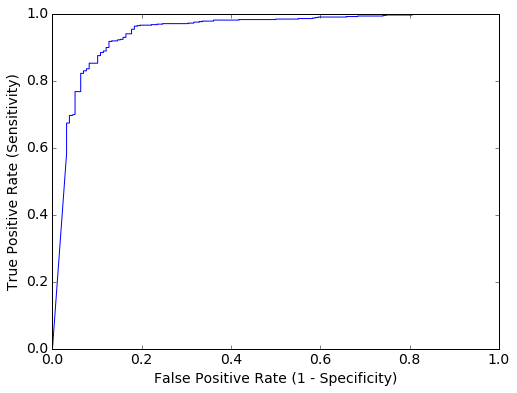

In [50]:
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14
fpr, tpr, thresholds = metrics.roc_curve(y_tf, y_pred_pos)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

### 8. Print the confusion matrix, and calculate the sensitivity and specificity. Comment on the results.

In [51]:
y_pred_tf = np.where(y_pred==1,0,1)

In [52]:
confusion = metrics.confusion_matrix(y_tf, y_pred_tf)
TP = confusion[1][1]
TN = confusion[0][0]
FP = confusion[0][1]
FN = confusion[1][0]
print confusion
# calculate the sensitivity
print TP / float(TP + FN)
# calculate the specificity
print TN / float(TN + FP)

[[108  50]
 [ 16 644]]
0.975757575758
0.683544303797


The high sensitivity shows that for all of the cases that are actually true, 98% of them will actually be identified as true and 2% will be misidentified as false. We mapped reviews with star ratings of 5 as true, so this means we are extremely good at correctly identifying 5-star ratings.

The lower sensitivity shows that for all of the cases that are actually false, 68% are correctly identified as false as 32% as true. We mapped 1-star ratings as false. This means that we are much less accurate in identifying 1-star ratings as actually 1-star. We have sacrificed some of our ability to identify 1-star ratings in order to better identify 5-star ratings. This tradeoff seems to maximize the overall accuracy. If it were actually more important to idnentify 1-star ratings, we may choose some other point on the ROC curve that would misidentify more 5-star ratings and may drop slighly in overall accuracy but would better identify 1-star restaurants.

The choice of where we would choose as the optimal point on the ROC curve could depend on the goal of the analysis.

### 9. Browse through the review text for some of the false positives and false negatives. Based on your knowledge of how Naive Bayes works, do you have any theories about why the model is incorrectly classifying these reviews?

Some false positives. These would be instances in which the true score was 1 but we predicted a 5.

In [53]:
print Xtest[y_tf < y_pred_tf].iloc[0]
print Xtest[y_tf < y_pred_tf].iloc[1]
print Xtest[y_tf < y_pred_tf].iloc[11]

Maybe their dogs are better, but breakfast sandwiches at Nathan's are disgusting! The English muffin was spongy, the eggs greasy, the bacon undercooked... And all premade and wrapped ready to melt together into mush with the cheese. Yuck!!!
I'm sad to report that we dined here for lunch and it was inedible:(  Chef Aaron please come by and monitor your staff.  We had the eggplant sandwich and is was a disaster.  It was so overly oily and the bun and fries overwhelmed the plate.  The shrimp and grits were so average with the shrimp being of low quality.  The beer menu looked fabulous.  So I guess if this is just a watering hole things will be fine...but if you choose to dine be prepared to leave hungry and unsatisfied.  We hope this turns around.  The decor is cool and the staff is really fun and helpful...and we are hopeful for a great place to visit in the "hood".
I would not recommend this place to anyone.  I went there looking for a gift.  I received no help.  The girl was too busy h

Many of these reviews contain several negations on positive words (see above), or the negative phrases they use do not have individual words that can easily be extracted. Also, some talk of hoped for improvement or start by identifying something positive in the review before discussing how much they disliked it.

Some false negatives. These would be instances in which the true score was 5 but we predicted a 1.

In [54]:
print Xtest[y_tf > y_pred_tf].iloc[0]
print Xtest[y_tf > y_pred_tf].iloc[1]
print Xtest[y_tf > y_pred_tf].iloc[11]

Brown bag chicken sammich, mac n cheese, fried okra, and the bourbon drink.  Nuff said.
Brought my car here b/c of the reviews I read on yelp. My fan was running excessively. The mechanic came and looked at my car. The coolant was low. He grabbed a can and filled it up. No charge. I then told him I needed new struts. He quoted me a price that was cheaper than the one quoted to me in CO a few months ago. I honestly didn't shop around for a cheaper price here in Phoenix, which is unlike me. The reviews here, and fixing my fan problem at no charge had me sold. It seems so rare to find an honest mechanic now-a-days, especially in this economy.  Made an appt. Car was finished super quick, in the time frame that was promised. The mechanic went out of his way to show me the damage struts he replaced, then told me my new struts came with a lifetime warranty. Dang, did I time warp back into the 50s?  Hopefully I won't have a need to go back, but if I do, I'd gladly drive out of my way one hour 

The false negatives are seem to stress how a negative situation was made better by the place that is being reviewed. Or in the first instance, it might be difficult even for a human to determine the rating based on the review.

### 10. Let's pretend that you want to balance sensitivity and specificity. You can achieve this by changing the threshold for predicting a 5-star review. What threshold approximately balances sensitivity and specificity?

In [55]:
thresholds[np.argmin(abs(1-fpr-tpr))]

0.9976114702693043

In [56]:
np.argmin(abs(1-fpr-tpr))

50

These seems extremely high, but we know that these probabilities are not expected to be particularly accurate. This means we would only predict a value as true if we calculated the probability of it being a true value of 99.76 or higher. This would give us about 88.4% of 5-star ratings and 88.6 of 1-star ratings. 

In [57]:
print 1-fpr[58]
print tpr[58]
#print thresholds

0.854430379747
0.919696969697


In [58]:
1-fpr[58]-tpr[58]

-0.065266589950134235

### 11. Let's see how well Naive Bayes performs when all reviews are included, rather than just 1-star and 5-star reviews:
* Define X and y using the original DataFrame from step 1. (y should contain 5 different classes.)

In [59]:
X = yelp_data['text']
y = yelp_data['stars']

* Split the data into training and testing sets.

In [60]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=3)
# Test against solution
#Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=1)

* Calculate the testing accuracy of a Naive Bayes model.

In [61]:
vect = CountVectorizer()
vect.fit(Xtrain)
yelp_train_dtm = vect.transform(Xtrain)
yelp_test_dtm = vect.transform(Xtest)
nb = MultinomialNB()
nb.fit(yelp_train_dtm, ytrain)
y_pred = nb.predict(yelp_test_dtm)
metrics.accuracy_score(ytest, y_pred)

0.47899999999999998

* Compare the testing accuracy with the null accuracy.

In [62]:
max(y.value_counts())/float(len(y))

0.35260000000000002

Improve from 35% accurate by always guessing four star to 48% by using naive bayes learning.

* Print the confusion matrix.

In [63]:
confusion = metrics.confusion_matrix(ytest, y_pred)
confusion

array([[ 53,  29,  13,  50,  21],
       [ 13,  19,  30,  98,  17],
       [  5,  12,  34, 231,  34],
       [  5,   5,  21, 491, 162],
       [  3,   2,   6, 285, 361]])

* Comment on the results

The model knows that there are more fours and fives and hedges its bets to maximize accuracy by overpredicting the number of fours and fives. If you like at the one star and two star ratings most of the true ones and twos are predicted as fours or fives. For a true five, we would almost always predict a four or five. Similar for true fours, very little of the fours leaks into the threes.